In [1]:
import sys
sys.path.append('../modules')
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from krippendorff import alpha as krippendorff_alpha
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
from seeDistinctValues import seeDistinctValues


df = pd.read_csv('merged_checked.csv')

# Convert column to datetime type
df['Q2.9.2'] = pd.to_datetime(df['Q2.9.2'])


df.head()

,id,title,label,annotator,Q1.1,Q1.2,Q1.3.1,Q1.4,Q1.5,Q1.6,...,Q1.7.1_3,Q1.7.1_4,Q1.7.1_5,Q1.7.1_6,Q1.7.1_7,Q1.7.1_8,Q1.7.1_9,Q1.7.1_10,Q1.7.1_11,Q1.7.1_12
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Manuel,1,2,-1,2,4,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Angelo,1,3,1,1,4,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Manuel,1,4,-1,2,4,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Marinella,1,4,-1,1,4,4,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
4,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Group 1,Manuel,2,3,-1,1,3,2,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


In [2]:
df.dtypes


id                   object
title                object
label                object
annotator            object
Q1.1                  int64
Q1.2                  int64
Q1.3.1                int64
Q1.4                  int64
Q1.5                  int64
Q1.6                  int64
Q1.7                  int64
Q1.7.1.2             object
Q2.8                  int64
Q2.9.1                int64
Q2.9.2       datetime64[ns]
Q2.10                 int64
Q1.3_1                int64
Q1.3_2                int64
Q1.3_3                int64
Q1.3_4                int64
Q1.3_5                int64
Q1.3_6                int64
Q1.3_7                int64
Q1.3_8                int64
Q1.3_9                int64
Q1.7.1_0              int64
Q1.7.1_1              int64
Q1.7.1_2              int64
Q1.7.1_3              int64
Q1.7.1_4              int64
Q1.7.1_5              int64
Q1.7.1_6              int64
Q1.7.1_7              int64
Q1.7.1_8              int64
Q1.7.1_9              int64
Q1.7.1_10           

In [3]:
seeDistinctValues(df)

Colonna annotator:
['Manuel' 'Angelo' 'Marinella' 'marinella' 'ChatGPT4AsAnnotator']
Colonna Q1.1:
[ 1  2  4  3  5 -1]
Colonna Q1.2:
[ 2  3  4  1 -1]
Colonna Q1.3.1:
[-1  1  2]
Colonna Q1.4:
[ 2  1 -1]
Colonna Q1.5:
[ 4  3  2  1 -1]
Colonna Q1.6:
[ 4  2  3  1 -1]
Colonna Q1.7:
[ 1  2 -1]
Colonna Q1.7.1.2:
['-1' 'Fashion craft industries system' 'Mass production'
 'Government of Morocco' 'Right-wing' 'AIFA' 'Italian' 'Italians' 'PD'
 'liberals' 'European Union' 'M5S' 'Giunta siciliana' 'Lega;Ostellari'
 'Minister Giovannini' 'Republican party' 'aifa' 'Who commits catcalling'
 'Letta' 'Davigo' 'CSM' 'Davigo; CSM' 'italian government' 'Lukashenko'
 'Judges' 'Biden' 'Letta; Biden; Hamas' 'Simon Levis Sullivan'
 'liberals, Simon levis' 'Defaulting citizens'
 'Politics;virologists;tv-shows' 'Magistrates' 'anti-racism' 'Speranza'
 'Person' 'National singers' 'chauvinists' 'Giuseppe Magliulo' 'Benetton'
 "D'Alema" 'The assassin' 'Figliuolo' 'Cremlin' 'Bolsonaro'
 'part of the judiciary' 'Guard

# Comparison

In [4]:
# Per ciascun articolo condiviso, calcola il coefficiente Kappa di Cohen
def getKappa (annotator_1, annotator_2):
# Inizializza una lista per memorizzare i coefficienti Kappa di Cohen
    kappa_scores = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
    set(df[df['annotator'] == annotator_2]['id']))
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]

        # Somma i valori delle colonne 'Q1.3_1' a 'Q1.3_9' per ciascun annotatore
        annotator1['Q1.3'] = annotator1[['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9']].sum(axis=1)
        annotator2['Q1.3'] = annotator2[['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9']].sum(axis=1)

        # Somma i valori delle colonne 'Q1.7.1_0' a 'Q1.7.1_12' per ciascun annotatore
        annotator1['Q1.7'] = annotator1[['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']].sum(axis=1)
        annotator2['Q1.7'] = annotator2[['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']].sum(axis=1)

        
        # Rimuovi le colonne 'Q1.3_1' a 'Q1.3_9'
        annotator1 = annotator1.drop(columns=['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9'])
        annotator2 = annotator2.drop(columns=['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9'])

        # Rimuovi le colonne 'Q1.7.1_0' a 'Q1.7.1_12'
        annotator1 = annotator1.drop(columns=['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12'])
        annotator2 = annotator2.drop(columns=['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12'])

        # Flatten the DataFrame to a 1D array
        annotator1_values = annotator1.values.flatten()
        annotator2_values = annotator2.values.flatten()

        # Calculate Cohen's Kappa
        k = cohen_kappa_score(annotator1_values, annotator2_values)
        kappa_scores.append(k)


        # Converti i valori in numeri interi o float
        annotator1 = annotator1.astype(float)
        annotator2 = annotator2.astype(float)
        
        # Calcola il coefficiente Kappa di Cohen per ciascuna coppia di annotatori
        k = cohen_kappa_score(annotator1.values.flatten(), annotator2.values.flatten())
        kappa_scores.append(k)

    if (len(kappa_scores) > 0):
        mean_kappa = sum(kappa_scores) / len(kappa_scores)
    else:
        print('Non ci sono annotazioni in comune tra gli annotatori ' + str(annotator_1) + ' e ' + str(annotator_1))
        return ()
    print ('Il K tra ' + str(annotator_1) +' e ' + str(annotator_2) +' è  di: '  + str(mean_kappa))
    return mean_kappa

out = getKappa('Manuel', 'Angelo')
out = getKappa('Manuel', 'Marinella')
out = getKappa('Angelo', 'Marinella')
print ('------------------------------------------')
out = getKappa('ChatGPT4AsAnnotator', 'Marinella')
out = getKappa('ChatGPT4AsAnnotator', 'Angelo')
out = getKappa('ChatGPT4AsAnnotator', 'Manuel')

Il K tra Manuel e Angelo è  di: 0.7349834518643247
Il K tra Manuel e Marinella è  di: 0.726670283557668
Il K tra Angelo e Marinella è  di: 0.721472892283669
------------------------------------------
Il K tra ChatGPT4AsAnnotator e Marinella è  di: 0.38740298037786175
Il K tra ChatGPT4AsAnnotator e Angelo è  di: 0.39564830427594866
Il K tra ChatGPT4AsAnnotator e Manuel è  di: 0.38171203188891356


In [5]:
import numpy as np

def getKrippendorff(df, annotator_1, annotator_2):
    # Inizializza una lista per memorizzare i coefficienti Krippendorff's alpha
    alpha_scores = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
        set(df[df['annotator'] == annotator_2]['id']))
    
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]


        # Somma i valori delle colonne 'Q1.3_1' a 'Q1.3_9' per ciascun annotatore
        annotator1['Q1.3'] = annotator1[['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9']].sum(axis=1)
        annotator2['Q1.3'] = annotator2[['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9']].sum(axis=1)

        # Somma i valori delle colonne 'Q1.7.1_0' a 'Q1.7.1_12' per ciascun annotatore
        annotator1['Q1.7'] = annotator1[['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']].sum(axis=1)
        annotator2['Q1.7'] = annotator2[['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']].sum(axis=1)

        
        # Rimuovi le colonne 'Q1.3_1' a 'Q1.3_9'
        annotator1 = annotator1.drop(columns=['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9'])
        annotator2 = annotator2.drop(columns=['Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9'])

        # Rimuovi le colonne 'Q1.7.1_0' a 'Q1.7.1_12'
        annotator1 = annotator1.drop(columns=['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12'])
        annotator2 = annotator2.drop(columns=['Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12'])

        # Flatten the DataFrame to a 1D array
        annotator1_values = annotator1.values.flatten()
        annotator2_values = annotator2.values.flatten()

        # Calculate Krippendorff's alpha
        alpha = krippendorff_alpha(np.array([annotator1_values, annotator2_values]))
        alpha_scores.append(alpha)

    if len(alpha_scores) > 0:
        mean_alpha = np.mean(alpha_scores)
        print('Il coefficiente di Krippendorff tra ' + annotator_1 + ' e ' + annotator_2 + ' è: ' + str(mean_alpha))
        return mean_alpha
    else:
        print('Non ci sono annotazioni in comune tra gli annotatori ' + annotator_1 + ' e ' + annotator_2)
        return None

# Usage example
out = getKrippendorff(df, 'Manuel', 'Angelo')
out = getKrippendorff(df, 'Manuel', 'Marinella')
out = getKrippendorff(df, 'Angelo', 'Marinella')
print('------------------------------------------')
out = getKrippendorff(df, 'ChatGPT4AsAnnotator', 'Marinella')
out = getKrippendorff(df, 'ChatGPT4AsAnnotator', 'Angelo')
out = getKrippendorff(df, 'ChatGPT4AsAnnotator', 'Manuel')


Il coefficiente di Krippendorff tra Manuel e Angelo è: 0.9867567328042353
Il coefficiente di Krippendorff tra Manuel e Marinella è: 0.9858401182291804
Il coefficiente di Krippendorff tra Angelo e Marinella è: 0.985491685968507
------------------------------------------
Il coefficiente di Krippendorff tra ChatGPT4AsAnnotator e Marinella è: 0.9636959234233624
Il coefficiente di Krippendorff tra ChatGPT4AsAnnotator e Angelo è: 0.9621338373812345
Il coefficiente di Krippendorff tra ChatGPT4AsAnnotator e Manuel è: 0.9590559899747181


Le statistiche tra Manuel e ChatGPT4AsAnnotator sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


Le statistiche tra Angelo e ChatGPT4AsAnnotator sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


Le statistiche tra Marinella e ChatGPT4AsAnnotator sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


Le statistiche tra Marinella e Manuel sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


Le statistiche tra Angelo e Manuel sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


Le statistiche tra Manuel e Angelo sono: 


/tmp/ipykernel_114528/158092795.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')


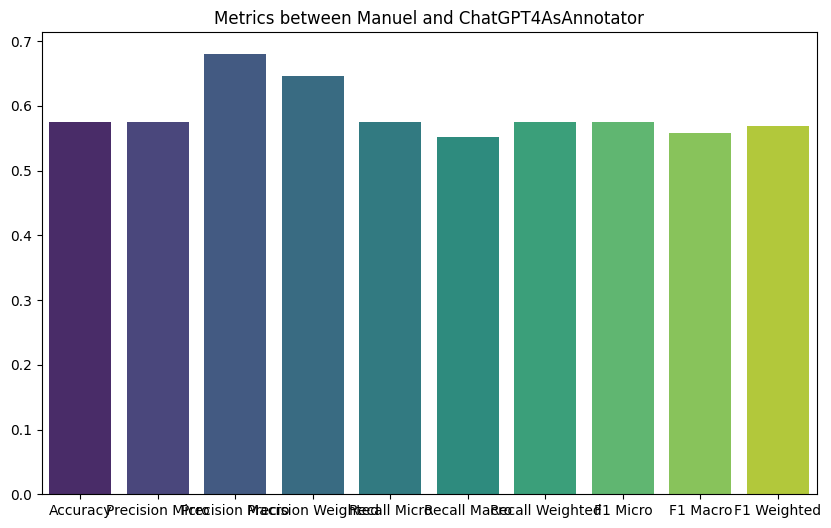

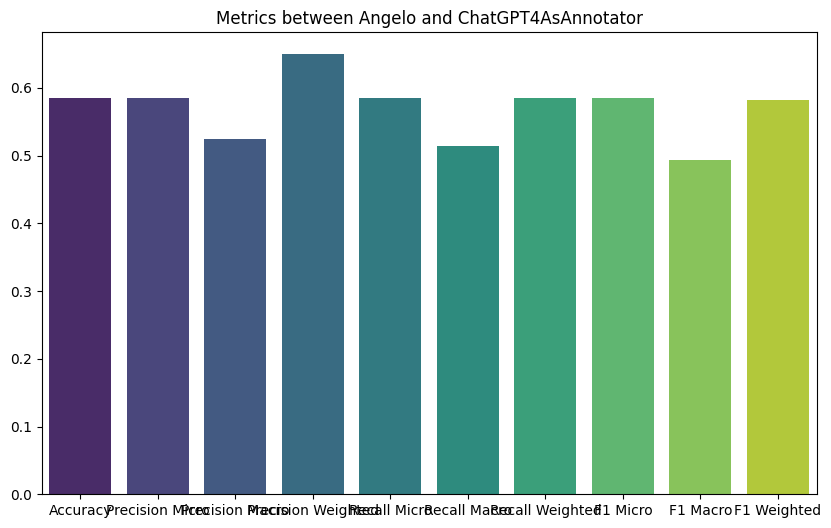

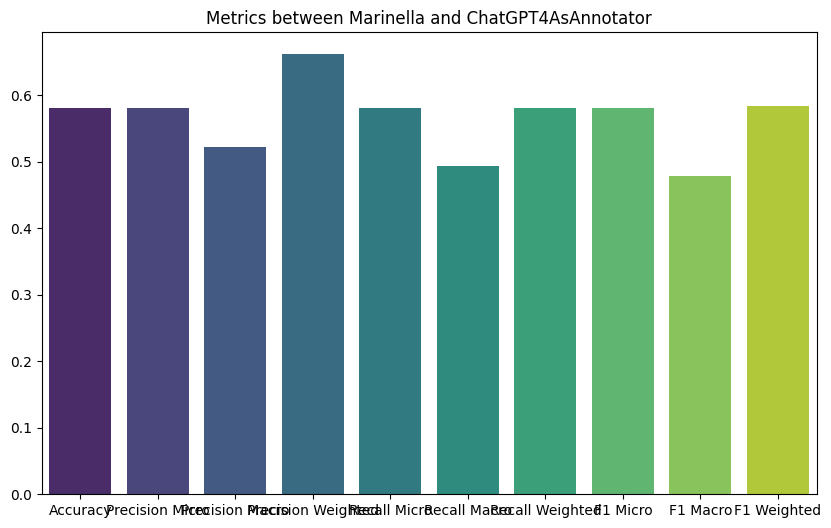

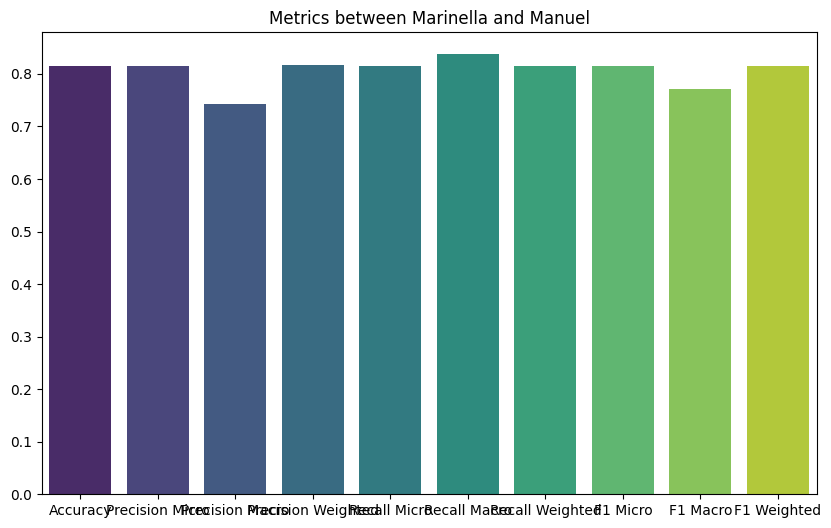

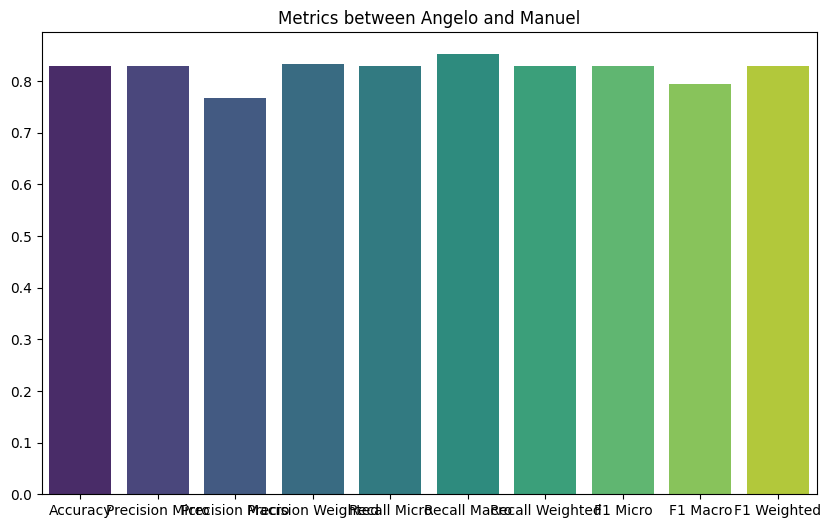

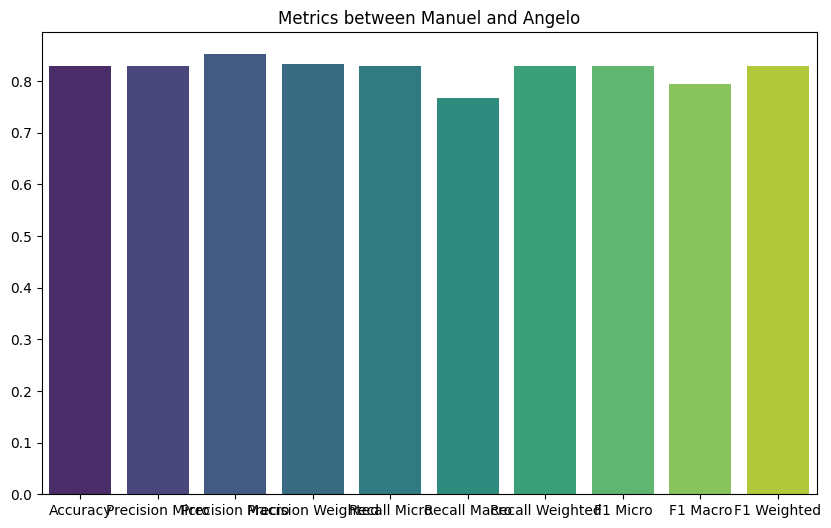

In [6]:
def calculate_metrics_sklearn(annotator_1, annotator_2, df):
    y_true = []
    y_pred = []
    sample_weights = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
        set(df[df['annotator'] == annotator_2]['id']))
    
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        
        annotator1 = annotator1.astype(str)
        annotator2 = annotator2.astype(str)
        
        for col in annotator1.columns:
            annotations_1 = annotator1[col].values.flatten()
            annotations_2 = annotator2[col].values.flatten()
            weight = 1.0  # Peso di default per le colonne non one-hot
            if col.startswith('Q1.3_'):  # Se la colonna è one-hot, assegna un peso minore
                weight = 1/9  # Per i 9 vaori possibili di 1.3
            if col.startswith('Q1.7.1_'):  # Se la colonna è one-hot, assegna un peso minore
                weight = 1/12  # Per i 12 valori possibili di Q1.7.1 
            for ann_1, ann_2 in zip(annotations_1, annotations_2):
                y_true.append(ann_1)
                y_pred.append(ann_2)
                sample_weights.append(weight)

    print('Le statistiche tra ' + str(annotator_1) + ' e ' + str(annotator_2) + ' sono: ')

    # Calcola le metriche
    acc = accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    prec_micro = precision_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0, sample_weight=sample_weights)
    prec_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0, sample_weight=sample_weights)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0, sample_weight=sample_weights)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0, sample_weight=sample_weights)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0, sample_weight=sample_weights)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0, sample_weight=sample_weights)

    # Creazione dei grafici
    metrics_names = ['Accuracy', 'Precision Micro', 'Precision Macro', 'Precision Weighted', 'Recall Micro', 'Recall Macro', 'Recall Weighted', 'F1 Micro', 'F1 Macro', 'F1 Weighted']
    metrics_values = [acc, prec_micro, prec_macro, prec_weighted, recall_micro, recall_macro, recall_weighted, f1_micro, f1_macro, f1_weighted]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y=metrics_values, x=metrics_names, palette='viridis')
    plt.title('Metrics between ' + str(annotator_1) + ' and ' + str(annotator_2))
    plt.xlabel



calculate_metrics_sklearn('Manuel','ChatGPT4AsAnnotator', df)
calculate_metrics_sklearn('Angelo','ChatGPT4AsAnnotator', df)
calculate_metrics_sklearn('Marinella','ChatGPT4AsAnnotator', df)
calculate_metrics_sklearn('Marinella','Manuel', df)
calculate_metrics_sklearn('Angelo','Manuel', df)
calculate_metrics_sklearn('Manuel','Angelo', df)

/tmp/ipykernel_114528/500486983.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis', ax=ax)
/tmp/ipykernel_114528/500486983.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis', ax=ax)
/tmp/ipykernel_114528/500486983.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis', ax=ax)
/tmp/ipykernel_114528/500486983.py:51: FutureWarning: 

Passing 

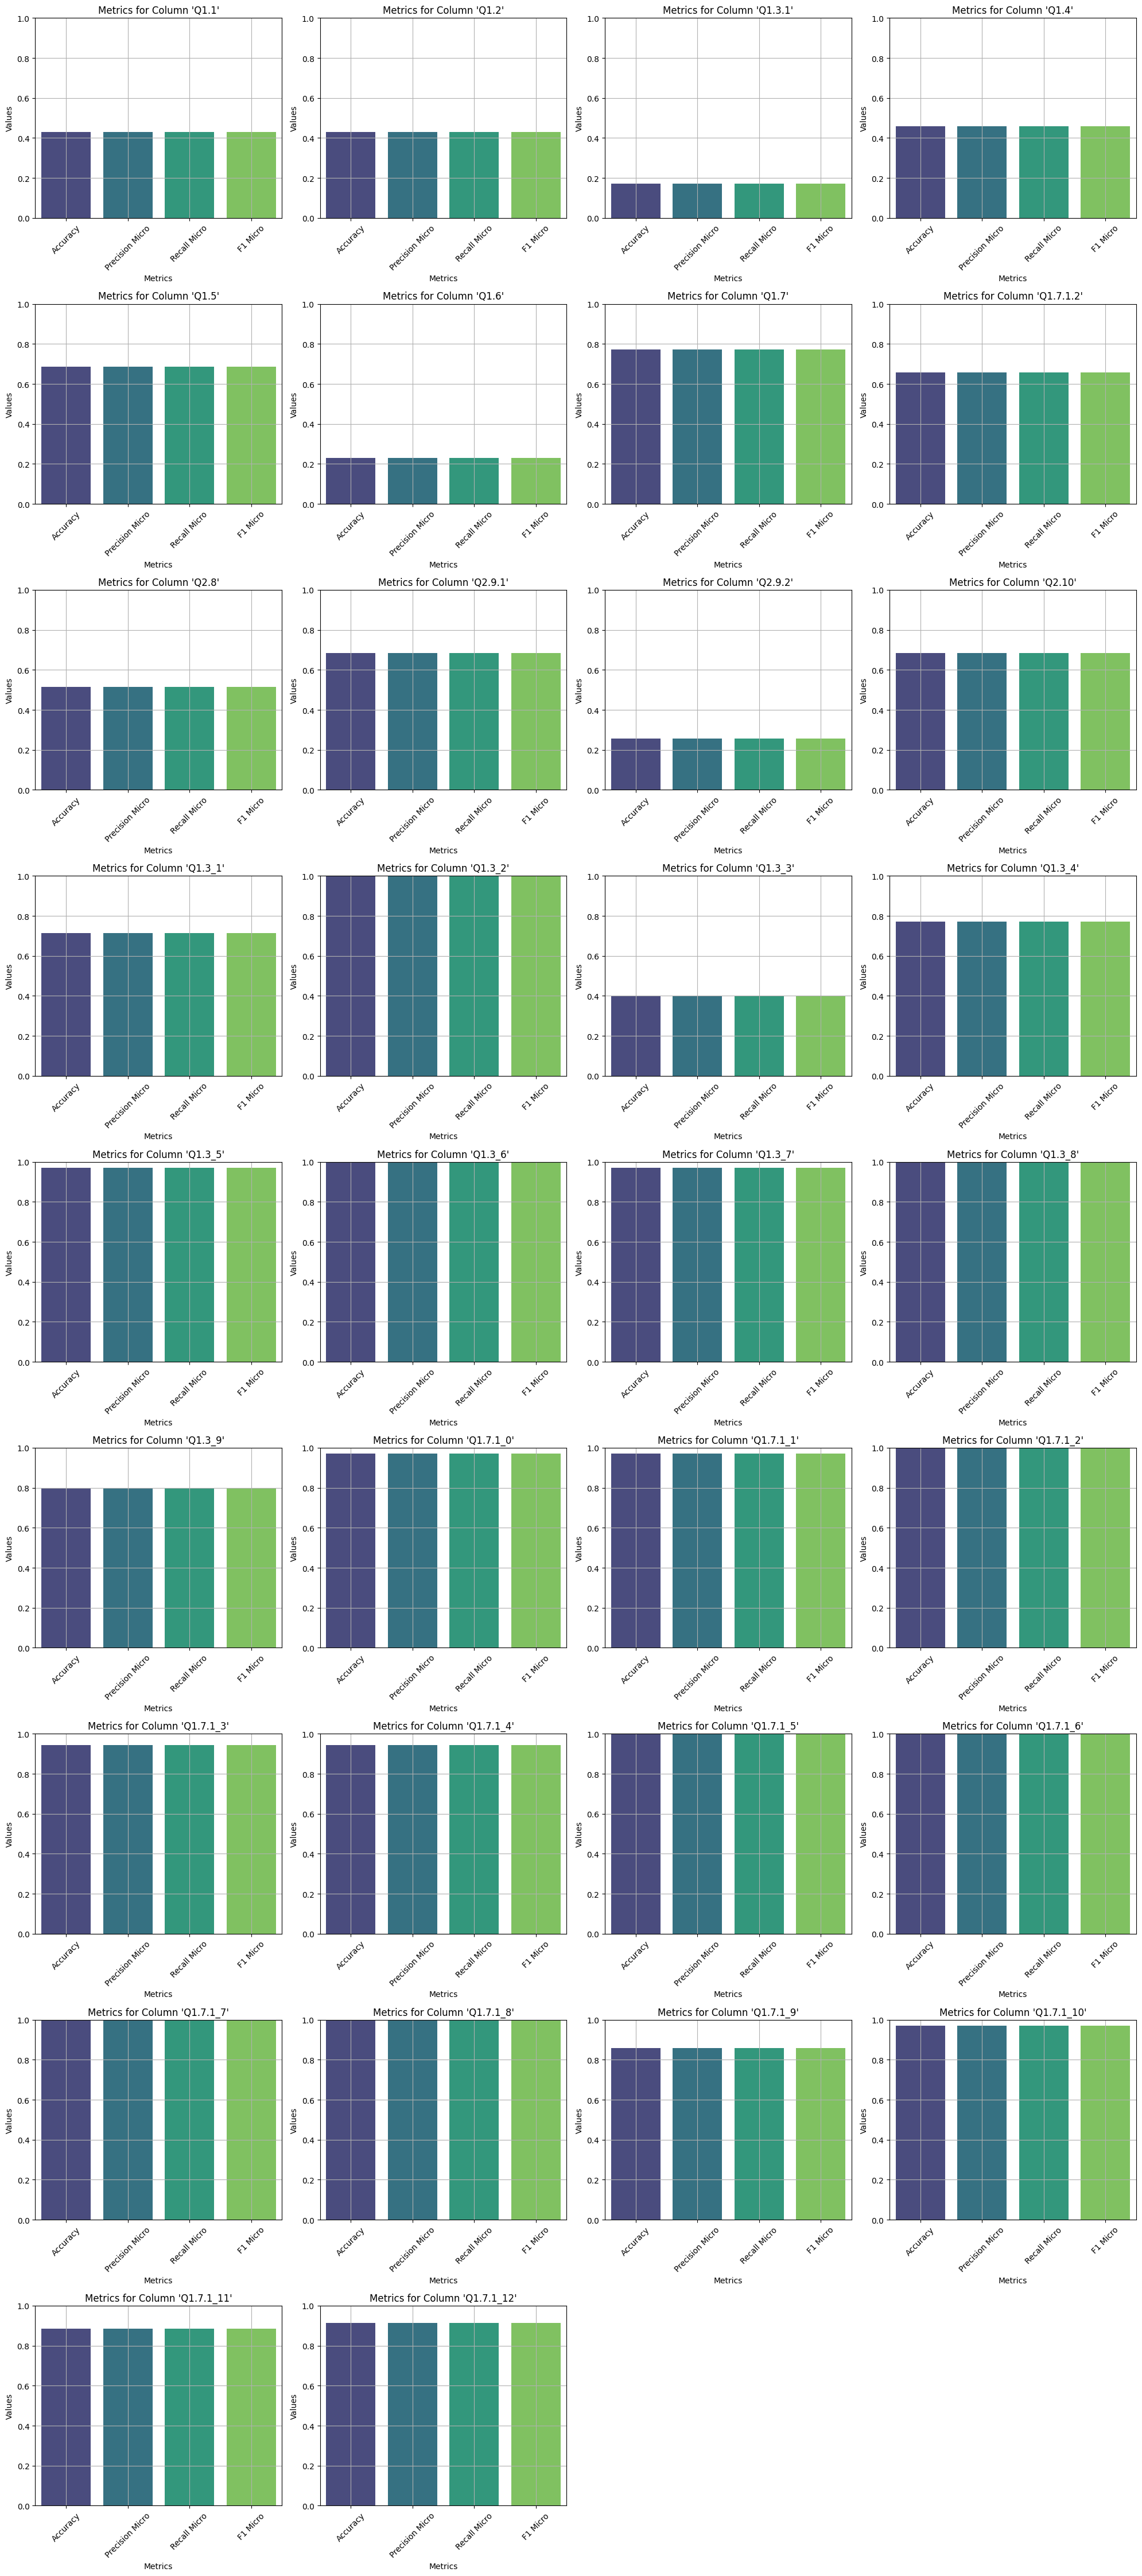

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics_per_column(annotator_1, annotator_2, df):
    metrics_per_column = {}

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
        set(df[df['annotator'] == annotator_2]['id']))
    
    for column in df.columns:
        if column not in ['id', 'annotator','title', 'label']:  # Ignora le colonne di identificazione
            y_true = []
            y_pred = []
            sample_weights = []
            for article_id in articles:
                annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][column]
                annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][column]

                
                annotator1 = annotator1.astype(str)
                annotator2 = annotator2.astype(str)
                
                annotations_1 = annotator1.values.flatten()
                annotations_2 = annotator2.values.flatten()
                
                weight = 1.0  # Peso di default per le colonne non one-hot                    
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)
                    sample_weights.append(weight)
            
            # Calcola le metriche per la colonna corrente
            acc = accuracy_score(y_true, y_pred, sample_weight=sample_weights)
            prec_micro = precision_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)
            recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)
            f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0, sample_weight=sample_weights)

            # Salva le metriche nella struttura dati
            metrics_per_column[column] = {'Accuracy': acc, 'Precision Micro': prec_micro, 'Recall Micro': recall_micro, 'F1 Micro': f1_micro}

    # Plotting dei risultati
    columns = list(metrics_per_column.keys())
    num_columns = len(columns)
    rows = (num_columns + 3) // 4  # Calcola il numero di righe necessarie
    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    axes = axes.flatten()

    for i, (column, metrics) in enumerate(metrics_per_column.items()):
        ax = axes[i]
        sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis', ax=ax)
        ax.set_title(f"Metrics for Column '{column}'")
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_ylim(0, 1)  # Imposta i limiti dell'asse y da 0 a 1
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

    # Rimuove gli assi delle eventuali sottofigure vuote
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
calculate_metrics_per_column('Manuel', 'ChatGPT4AsAnnotator', df)


Manuel VS ChatGPT4AsAnnotator


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/Chat

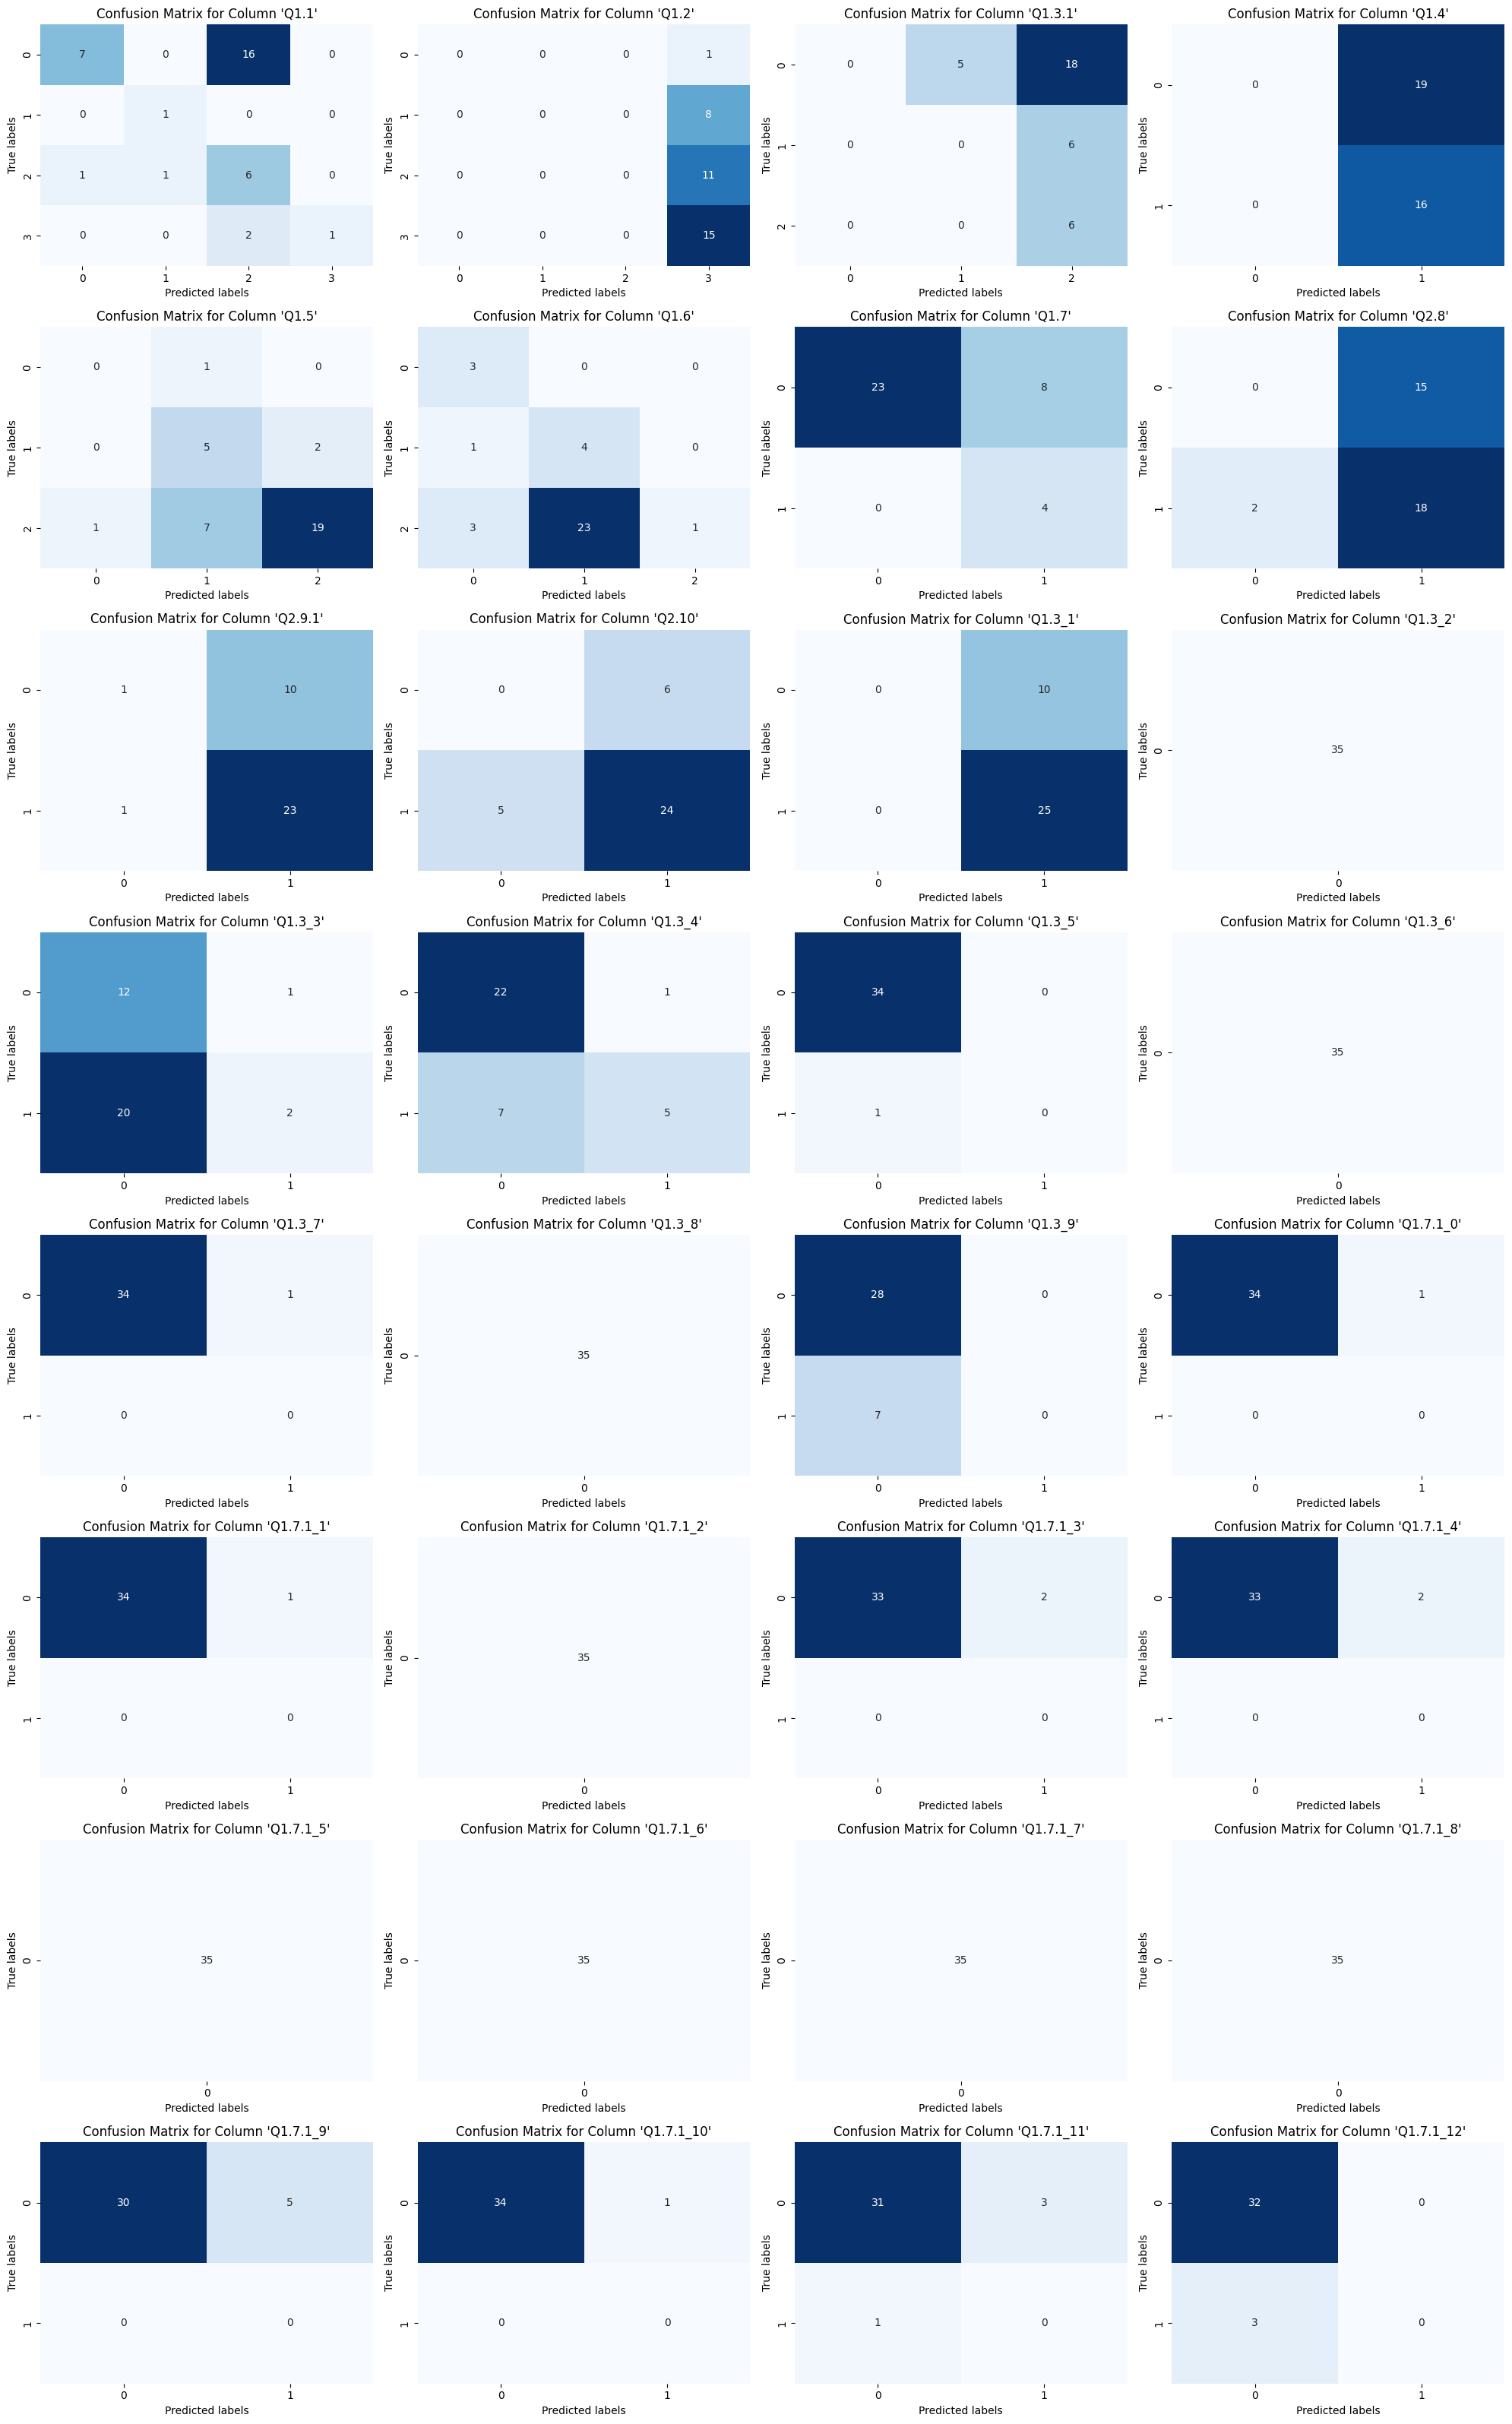

Angelo VS ChatGPT4AsAnnotator


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/Chat

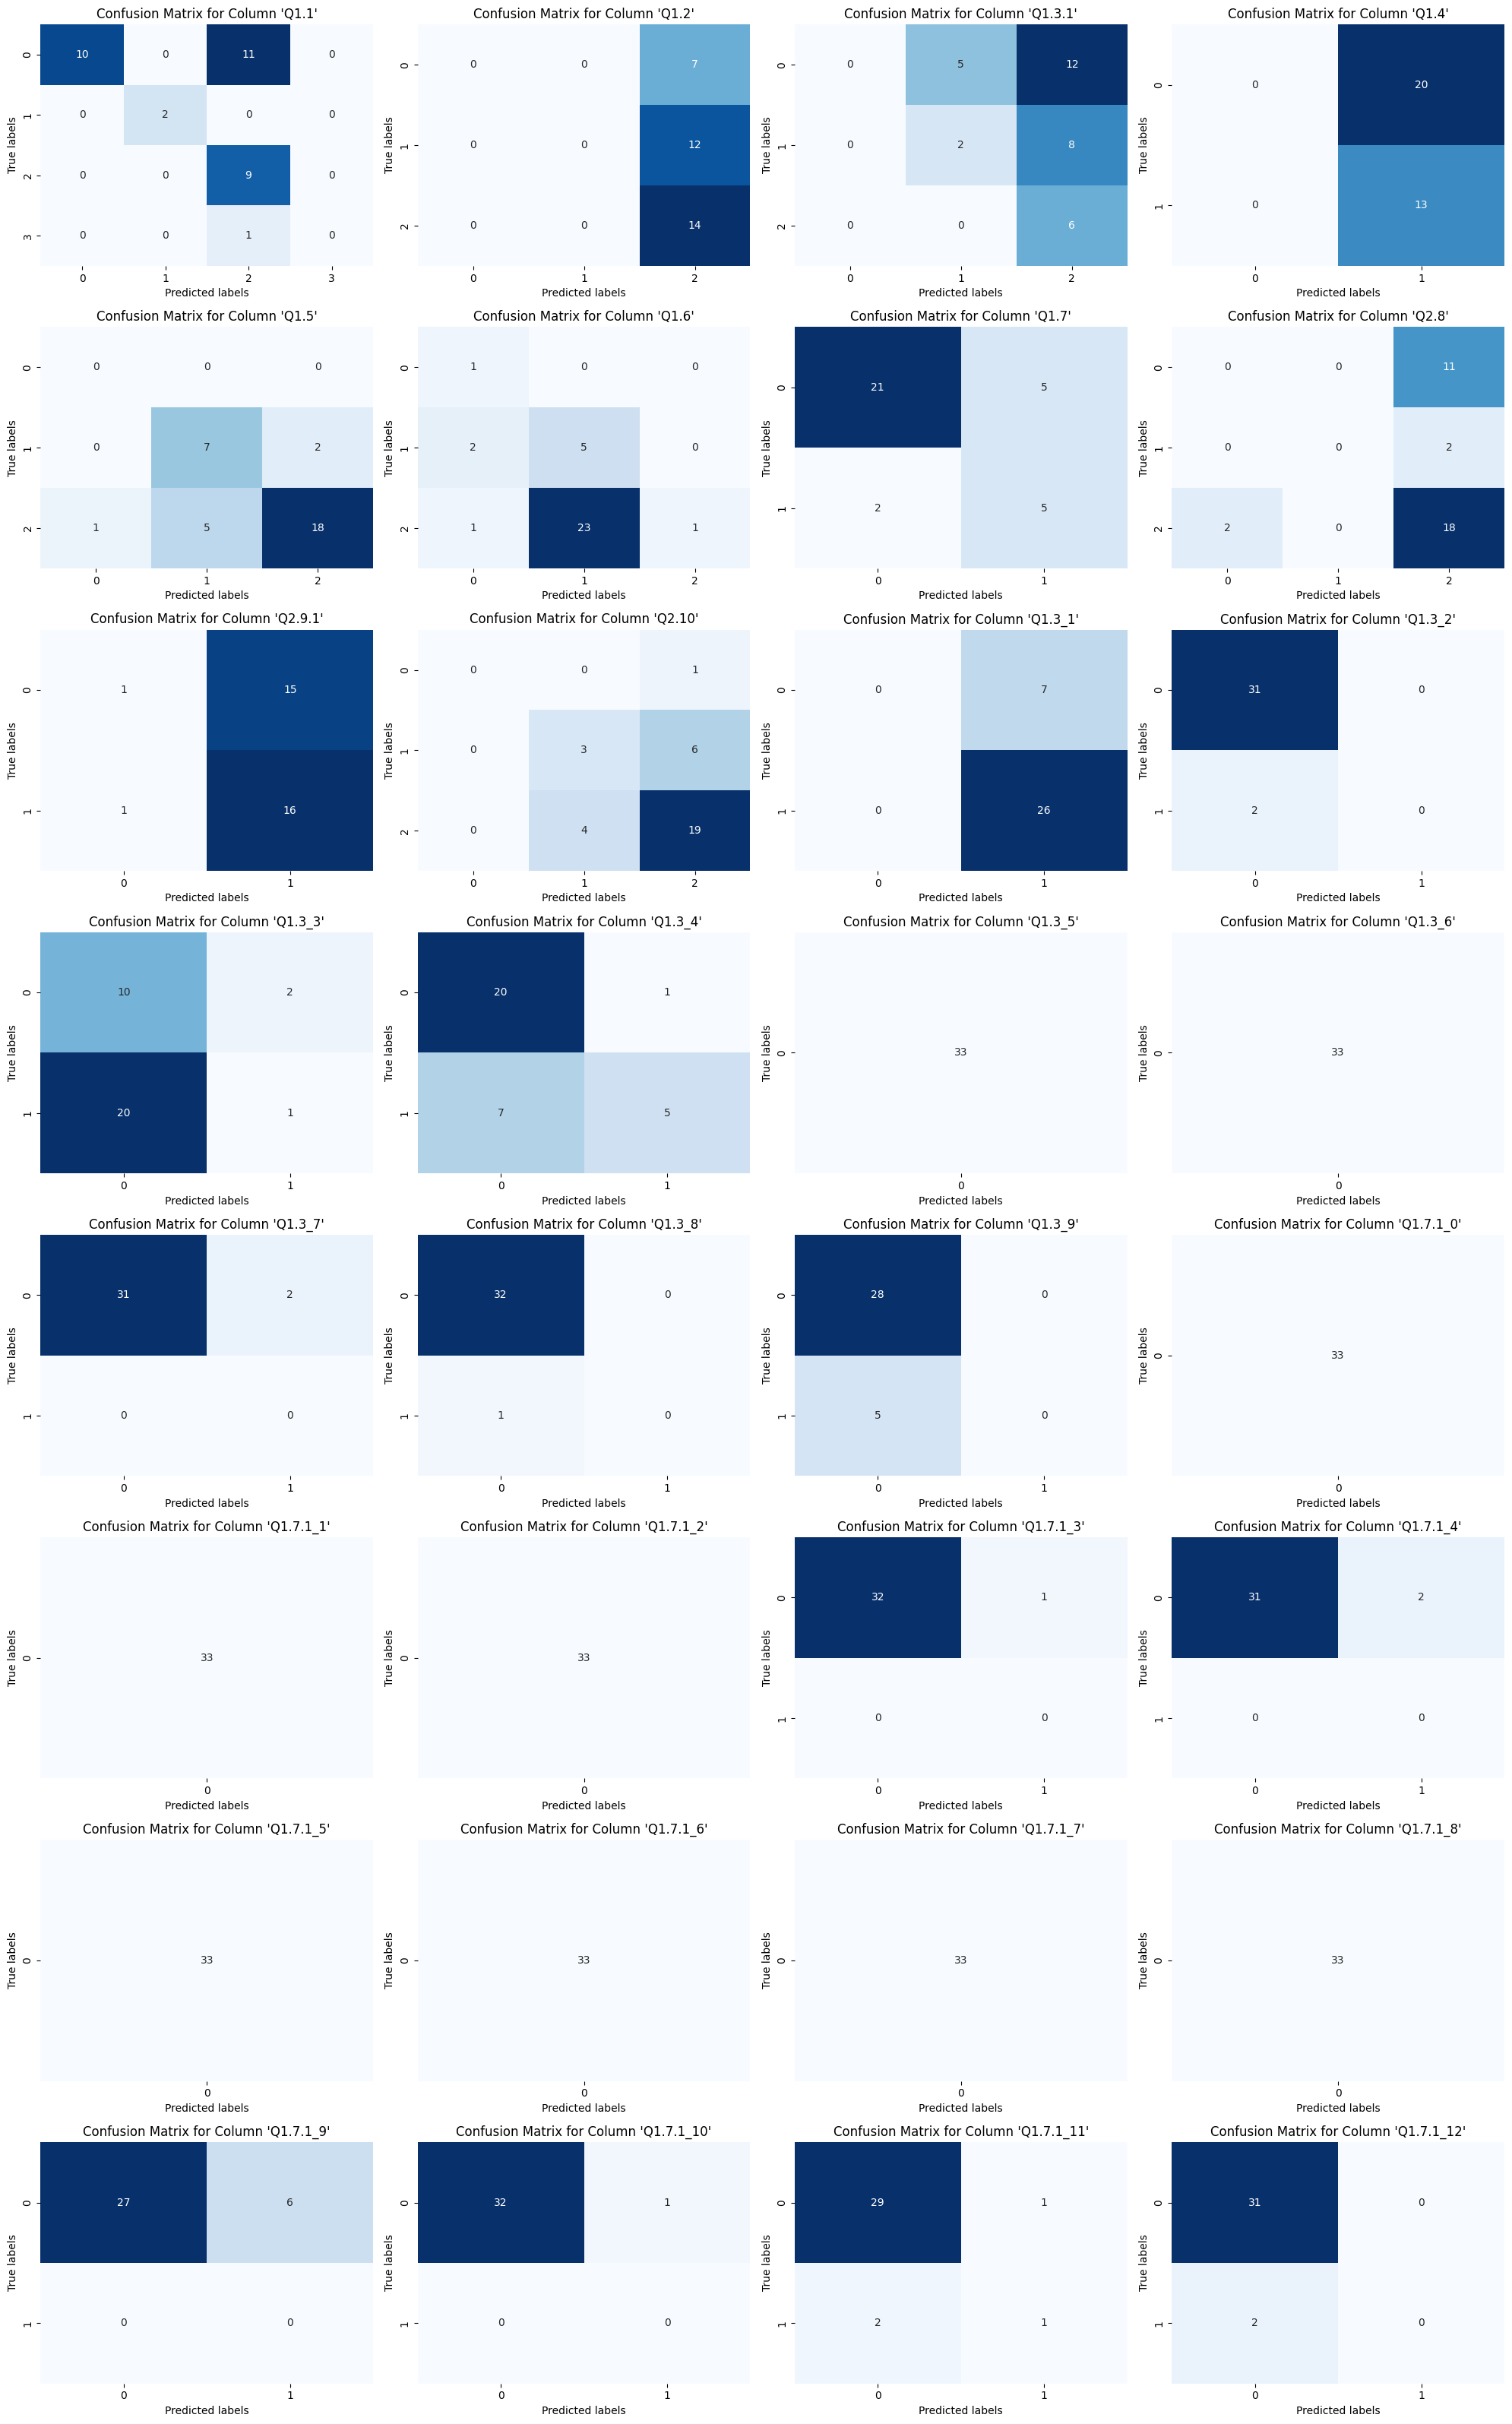

Marinella VS ChatGPT4AsAnnotator


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/Chat

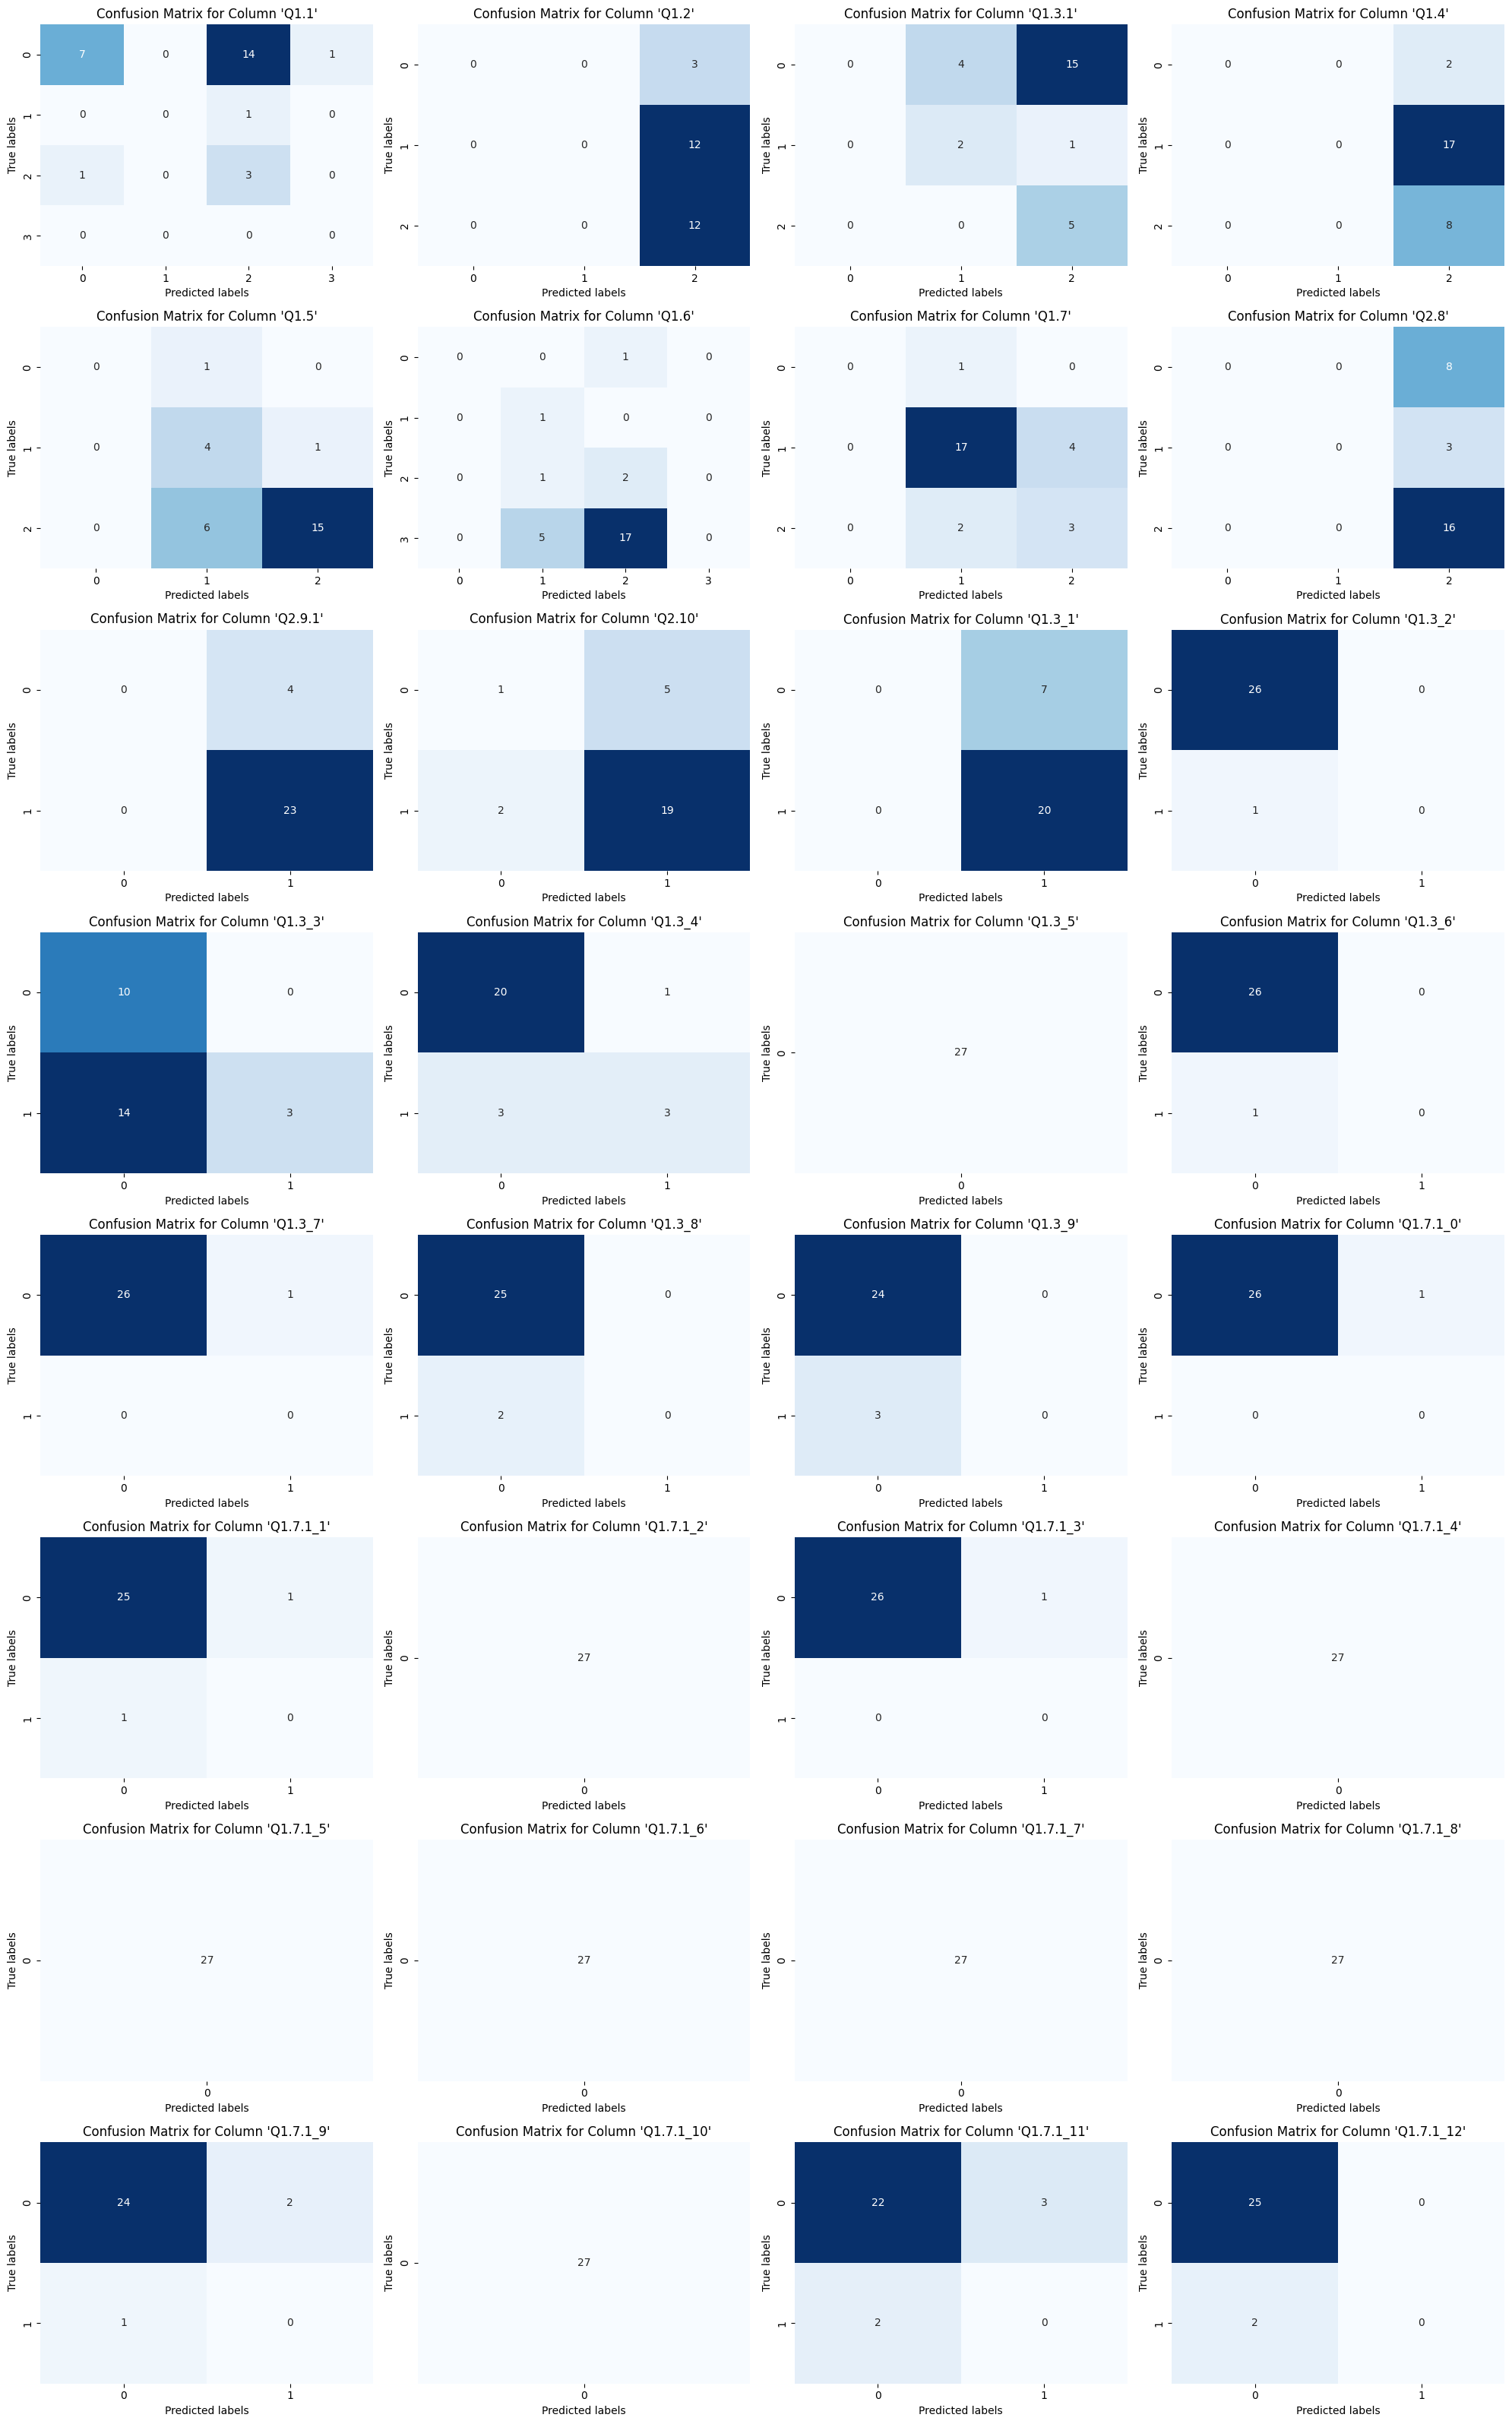

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred)
    plot_confusion_matrices(confusion_matrices)
    return 0

def plot_confusion_matrices(conf_matrices):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))  # Calcola il numero di righe necessarie per mostrare 4 matrici per riga
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4  # Calcola la riga corrente
        col = i % 4   # Calcola la colonna corrente
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']
print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider)
print('Angelo VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Angelo','ChatGPT4AsAnnotator', columns_to_consider)
print('Marinella VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Marinella','ChatGPT4AsAnnotator', columns_to_consider)


Manuel VS ChatGPT4AsAnnotator


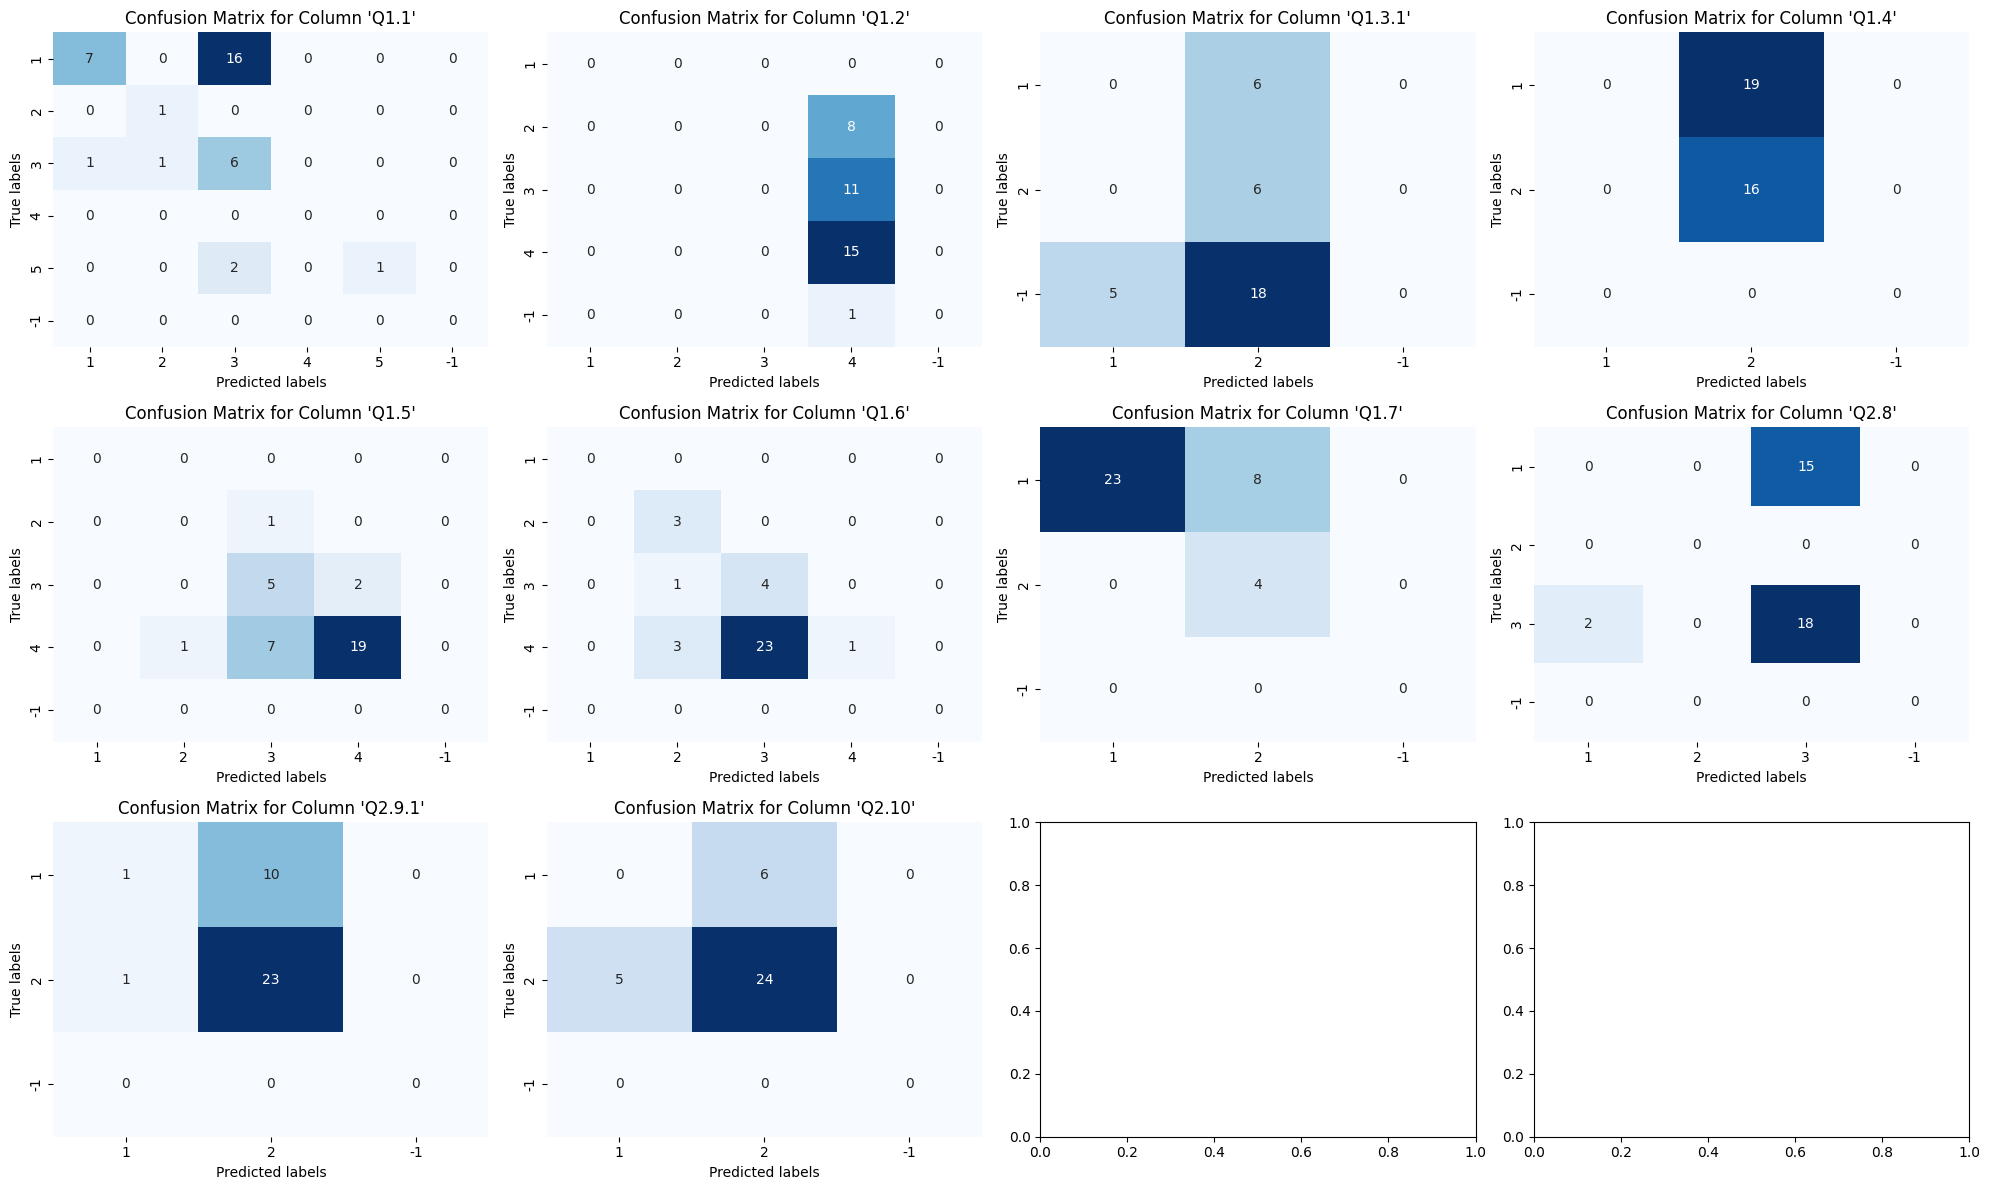

Angelo VS ChatGPT4AsAnnotator


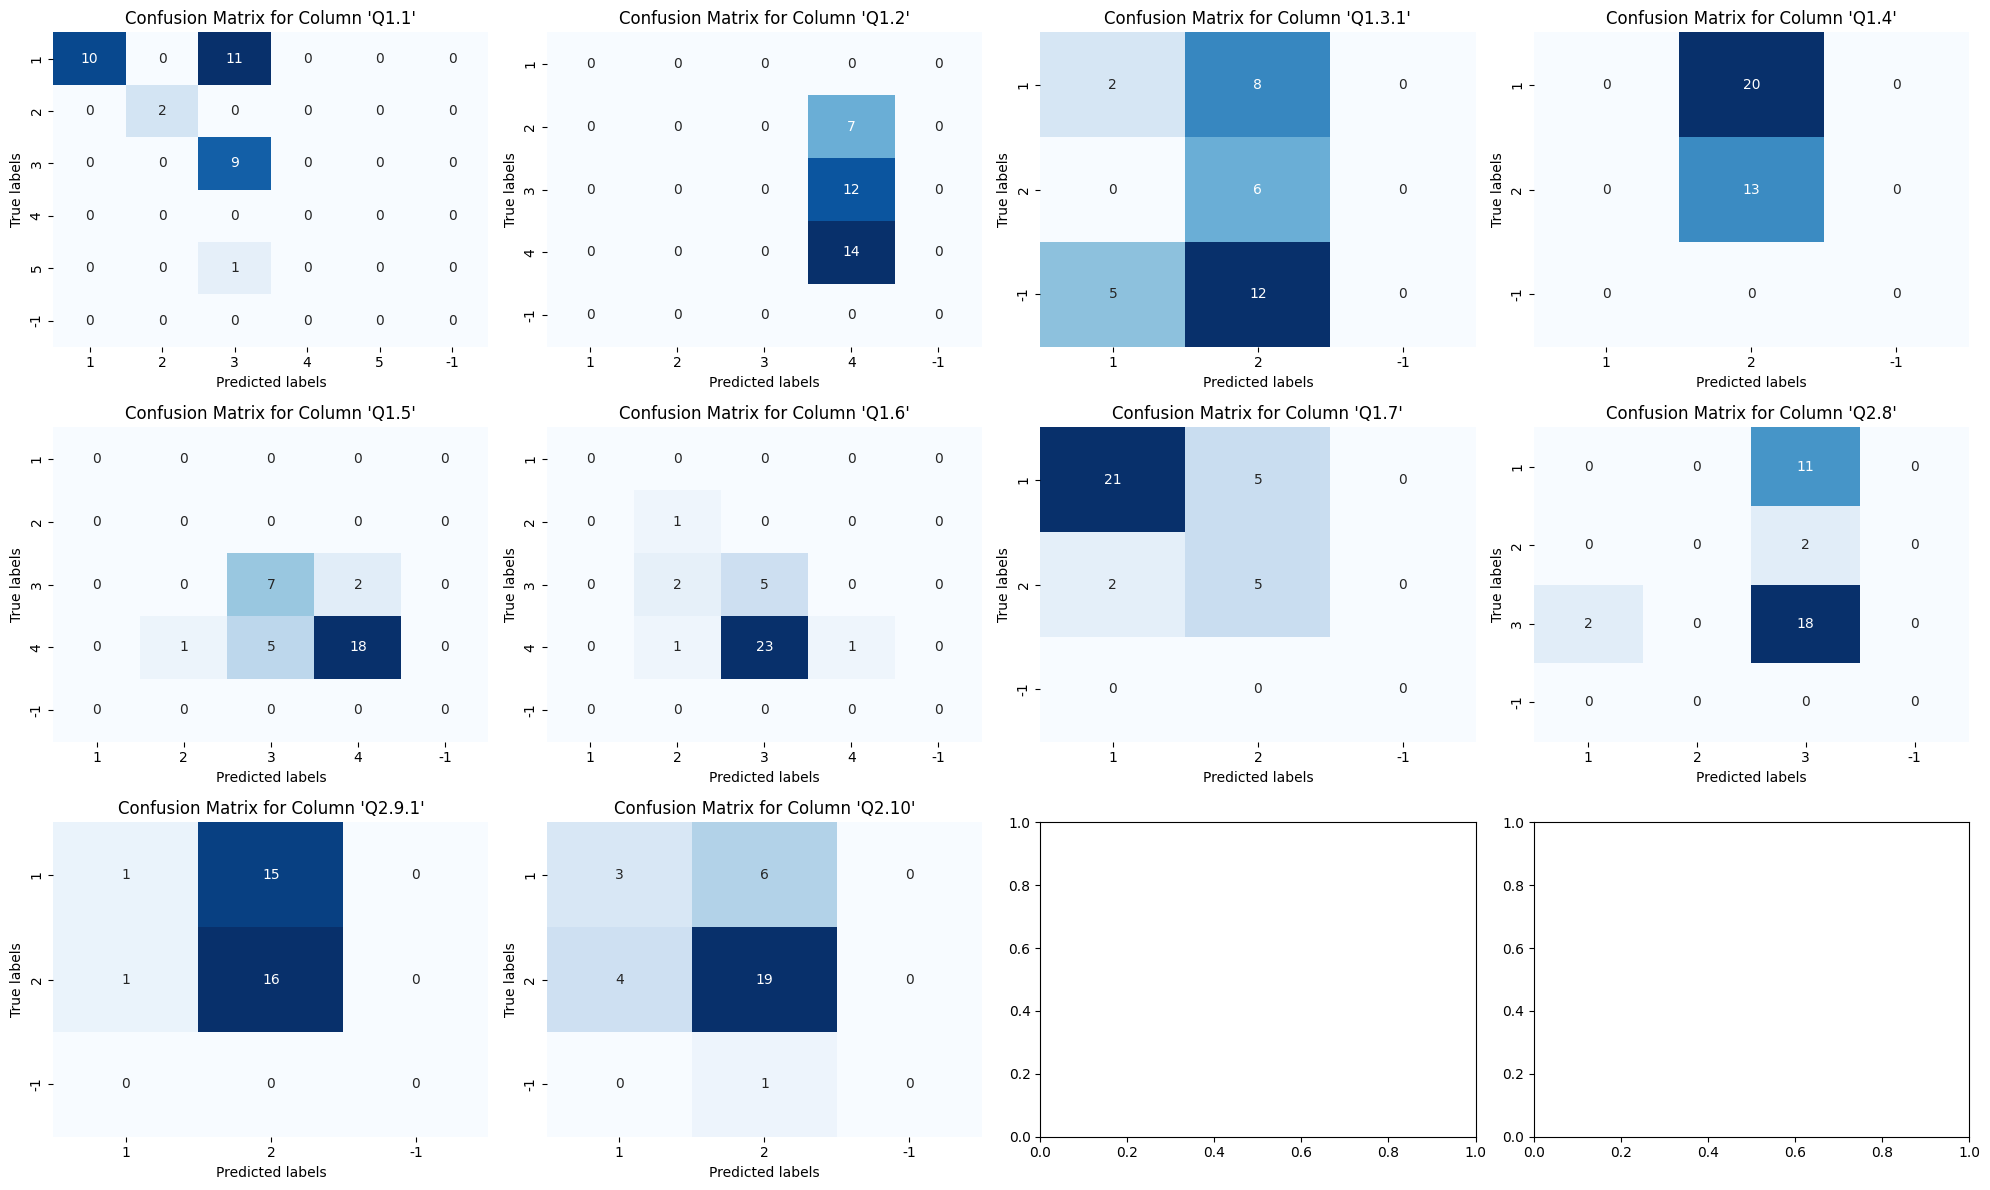

Marinella VS ChatGPT4AsAnnotator


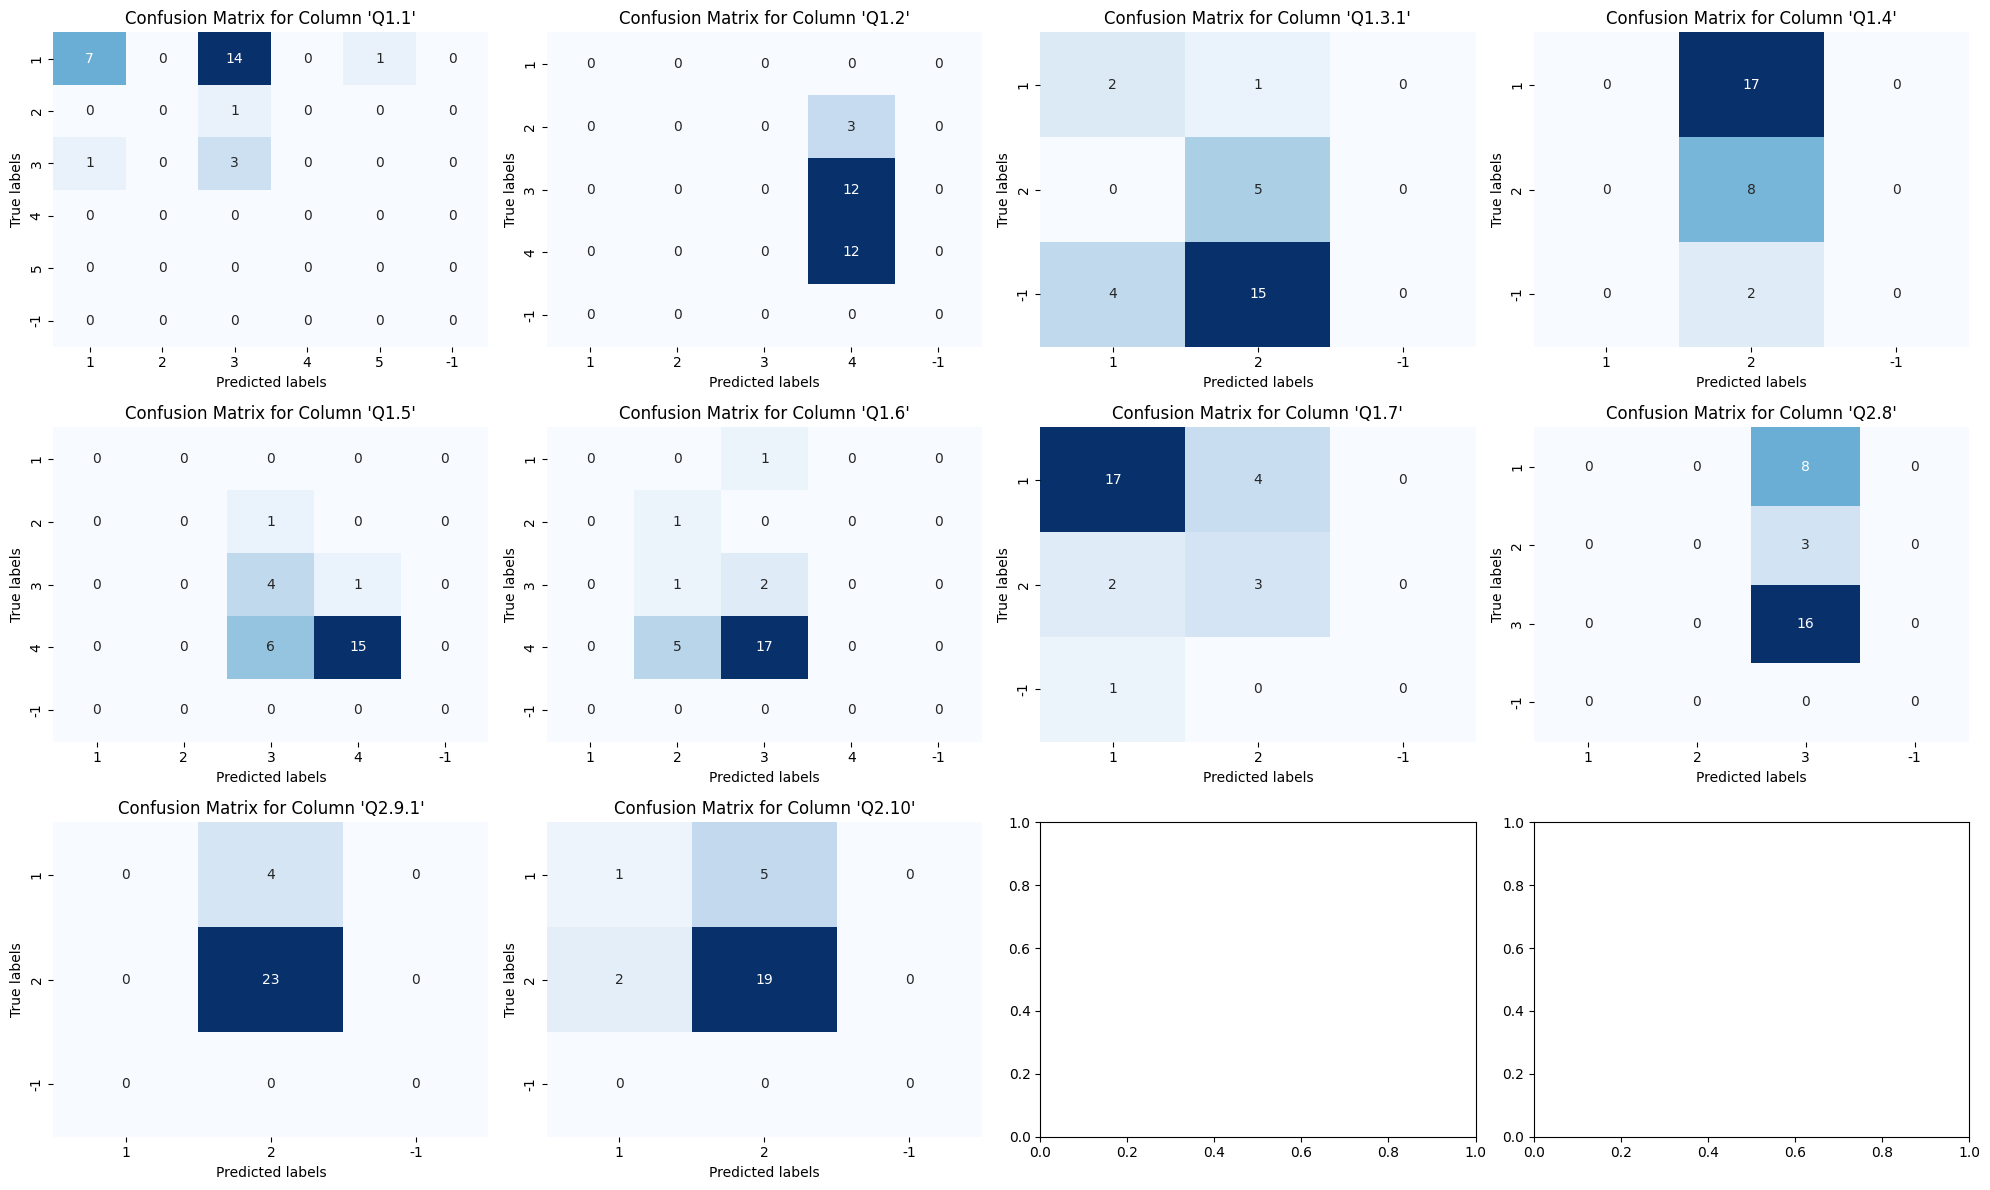

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10']
possible_values = {
    'Q1.1': ['1', '2', '3', '4', '5', '-1'], 
    'Q1.2': ['1', '2', '3', '4', '-1'],
    'Q1.3.1': ['1', '2', '-1'],
    'Q1.4': ['1', '2', '-1'],
    'Q1.5': ['1', '2', '3', '4', '-1'],
    'Q1.6': ['1', '2', '3', '4', '-1'],
    'Q1.7': ['1', '2', '-1'],
    'Q2.8': ['1', '2', '3', '-1'],
    'Q2.9.1': ['1', '2', '-1'],
    'Q2.10': ['1', '2', '-1']
}

print('Manuel VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)
print('Angelo VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Angelo','ChatGPT4AsAnnotator', columns_to_consider, possible_values)
print('Marinella VS ChatGPT4AsAnnotator')
conf_matrices = calculate_confusion_matrix('Marinella','ChatGPT4AsAnnotator', columns_to_consider, possible_values)
